# Demo of calibrated explanations on the speeddating dataset
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [Summary on the robustness of interpretability methods [Medium]](https://medium.com/@mohamadt/summary-on-the-robustness-of-interpretability-methods-ffb26ba22776)
2. [On the Robustness of Interpretability Methods [Arxiv]](https://arxiv.org/pdf/1806.08049.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lime import lime_tabular
from calibrated_explanations import CalibratedExplainer, __version__
import pandas as pd 
import time

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.7.0


In [3]:
dataSet = 'speeddating'
delimiter = ','

fileName = '../../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
df = df.dropna()
df = df.drop(['has_null'], axis=1)
target = 'match'

In [4]:
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        df[col] = df[col].map(mapping)
print(categorical_labels)

{1: {0: 'female', 1: 'male'}, 5: {0: '[0-1]', 1: '[2-3]', 2: '[4-6]', 3: '[7-37]'}, 6: {0: 'Asian/Pacific Islander/Asian-American', 1: 'Black/African American', 2: 'European/Caucasian-American', 3: 'Latino/Hispanic American', 4: 'Other'}, 7: {0: 'Asian/Pacific Islander/Asian-American', 1: 'Black/African American', 2: 'European/Caucasian-American', 3: 'Latino/Hispanic American', 4: 'Other'}, 8: {0: '0', 1: '1'}, 11: {0: '[0-1]', 1: '[2-5]', 2: '[6-10]'}, 12: {0: '[0-1]', 1: '[2-5]', 2: '[6-10]'}, 13: {0: 'Applied Maths/Econs', 1: 'Art History/medicine', 2: 'Biomedical Engineering', 3: 'Business', 4: 'Business & International Affairs', 5: 'Business [MBA]', 6: 'Business- MBA', 7: 'Chemistry', 8: 'Classics', 9: 'Communications', 10: 'Computer Science', 11: 'Economics', 12: 'Economics and Political Science', 13: 'Economics; Sociology', 14: 'Educational Psychology', 15: 'Electrical Engineering', 16: 'Elementary/Childhood Education [MA]', 17: 'Engineering', 18: 'English', 19: 'Film', 20: 'Fin

In [5]:
df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,0,21.0,27.0,6.0,2,0,2,0,2.0,...,0,1,7.0,6.0,1,1,0.0,1,0,0
1,1.0,0,21.0,22.0,1.0,0,0,2,0,2.0,...,0,1,7.0,5.0,1,1,1.0,1,0,0
3,1.0,0,21.0,23.0,2.0,1,0,2,0,2.0,...,0,1,7.0,6.0,1,1,0.0,1,1,1
4,1.0,0,21.0,24.0,3.0,1,0,3,0,2.0,...,0,1,6.0,6.0,1,1,0.0,1,1,1
5,1.0,0,21.0,25.0,4.0,2,0,2,0,2.0,...,0,1,6.0,5.0,1,1,0.0,0,1,0


In [6]:
num_to_test = 10

X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
# X_train,y_train = shuffle(X_train, y_train)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)
print(y_test)

[0 0 0 0 0 1 1 1 1 1]


In [7]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [8]:
tic = time.time()
explainer = CalibratedExplainer(model, X_cal, y_cal, 
                                    feature_names=df.columns, 
                                    categorical_features=categorical_features,
                                    categorical_labels=categorical_labels)
print(f"Time taken: {(time.time()-tic)/num_to_test}")


Time taken: 0.006034159660339355


In [9]:
tic = time.time()
alternative_explanation = explainer.explore_alternatives(X_test)
print(f"Time taken to generate alternative rules per instance: {(time.time()-tic)/num_to_test}")

Time taken to generate alternative rules per instance: 4.146745753288269


C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive

Time taken plotting alternative rules per instance: 0.6914214372634888
Time taken constructing conjunctive rules per instance: 11.617566990852357


C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\_plots_legacy.py:562: UserWarning: FigureCanvasAgg is non-interactive

Time taken plotting alternative and conjunctive rules per instance: 0.8255130767822265


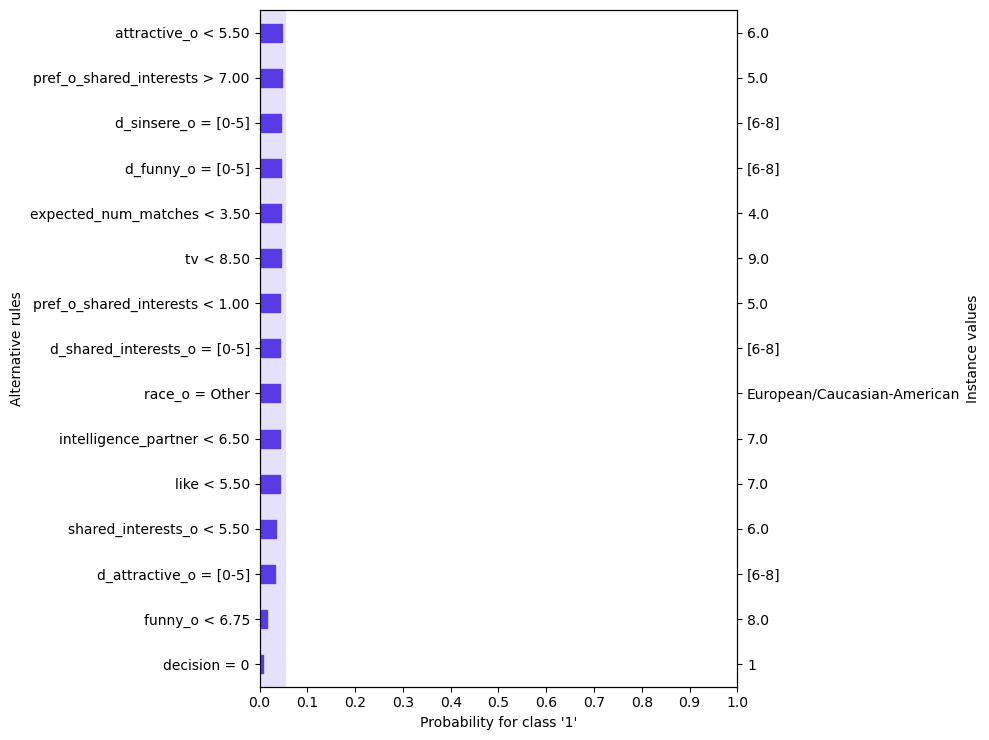

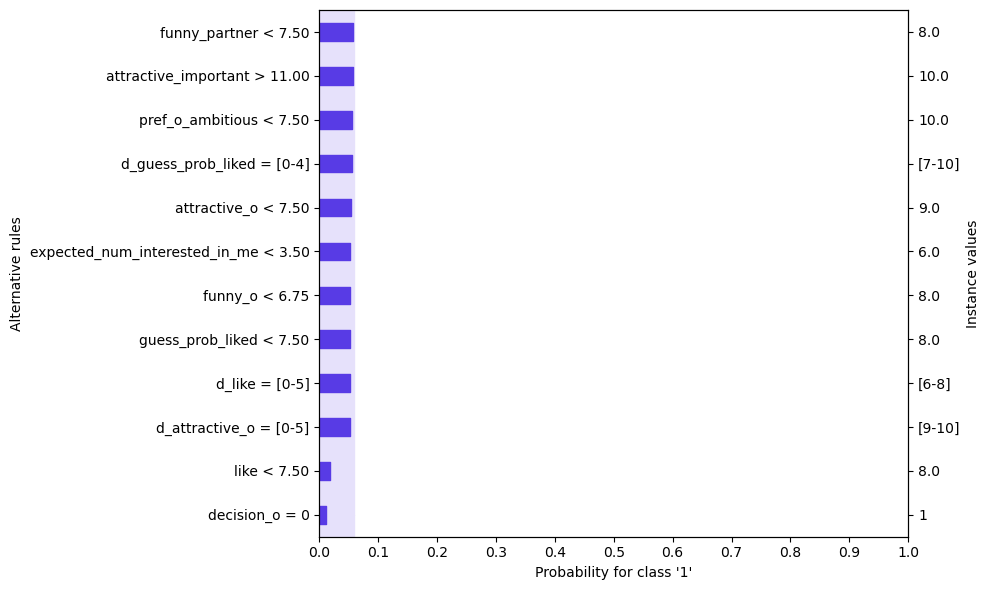

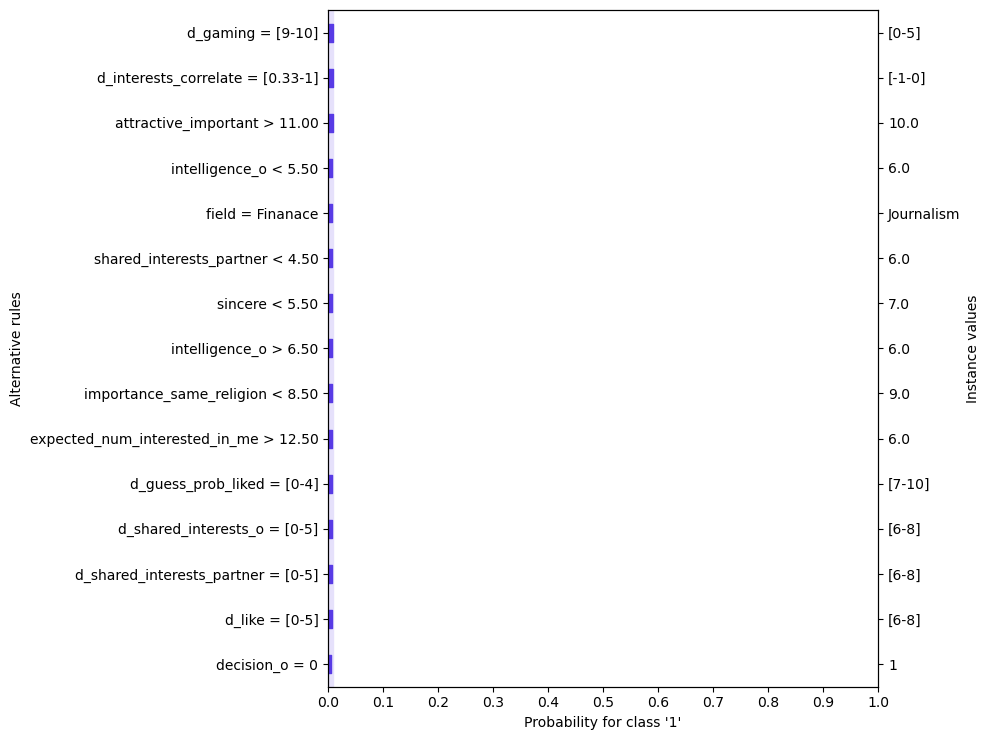

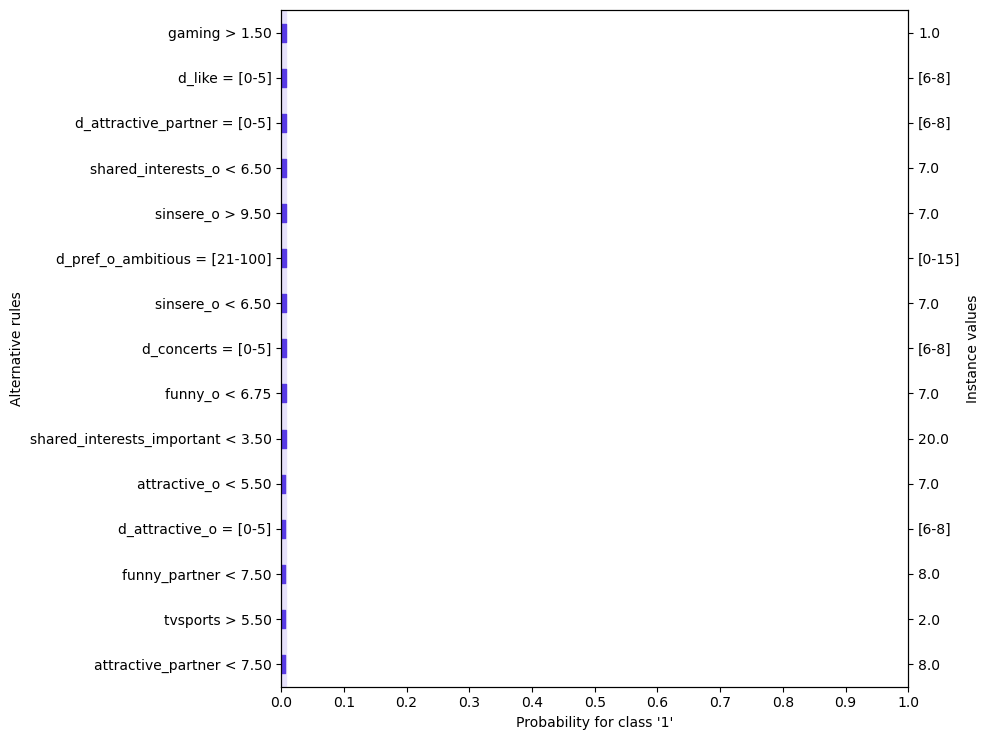

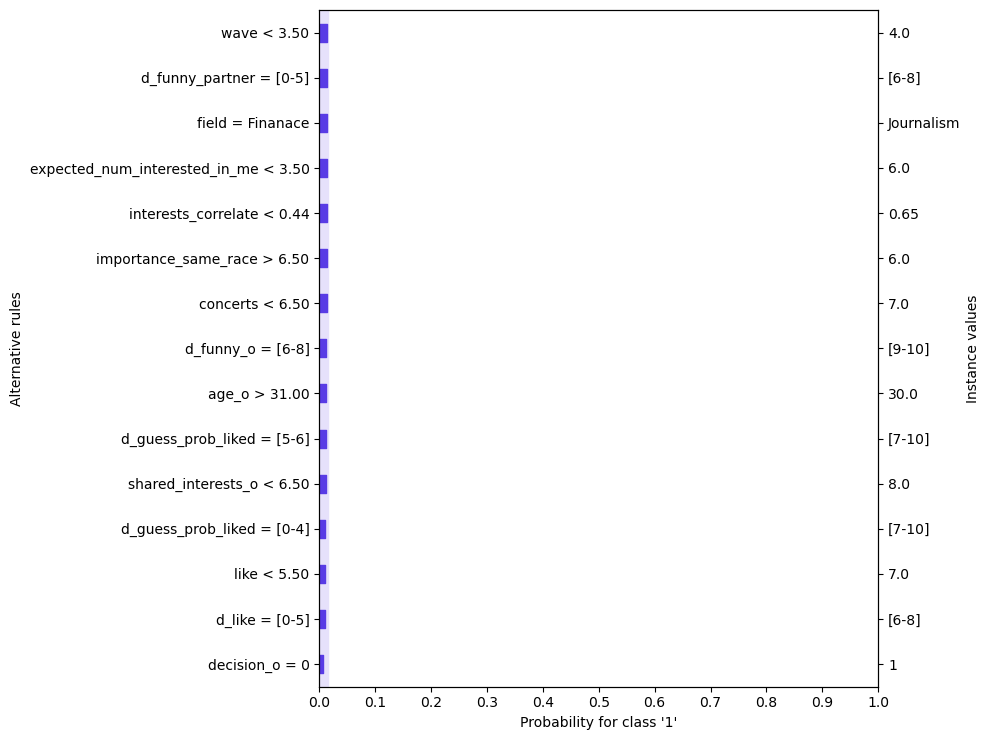

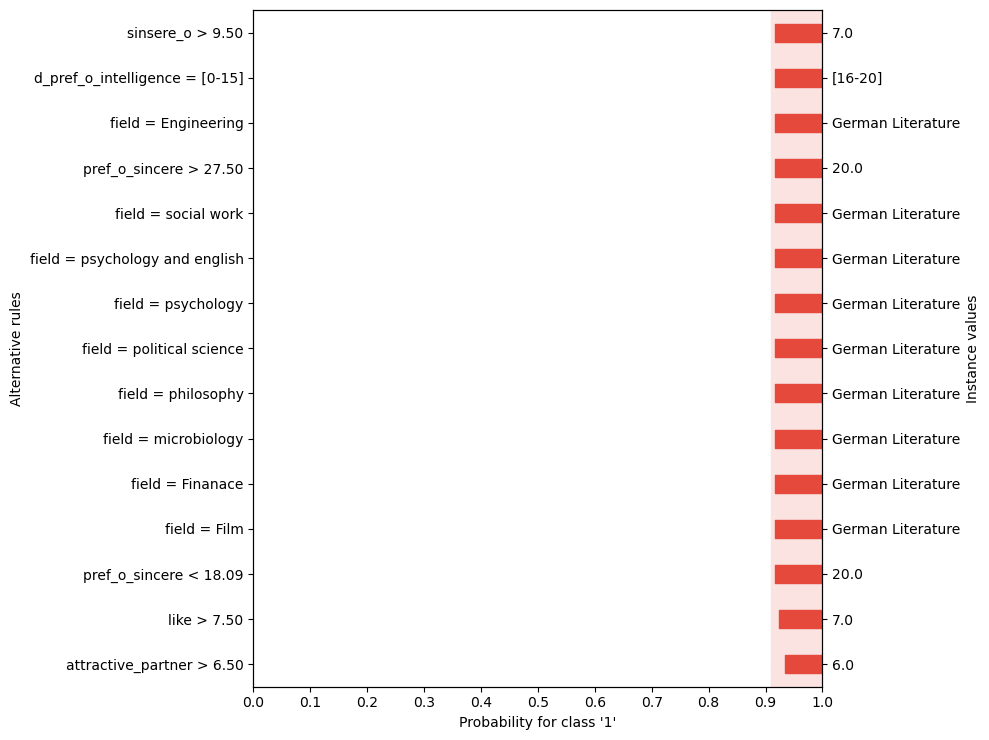

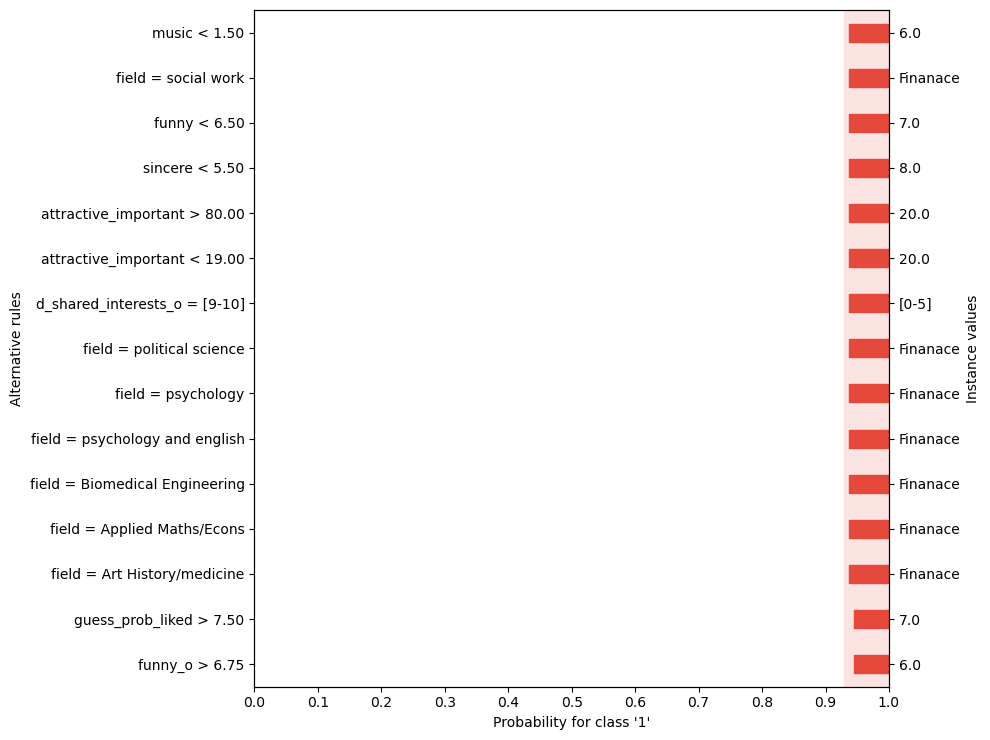

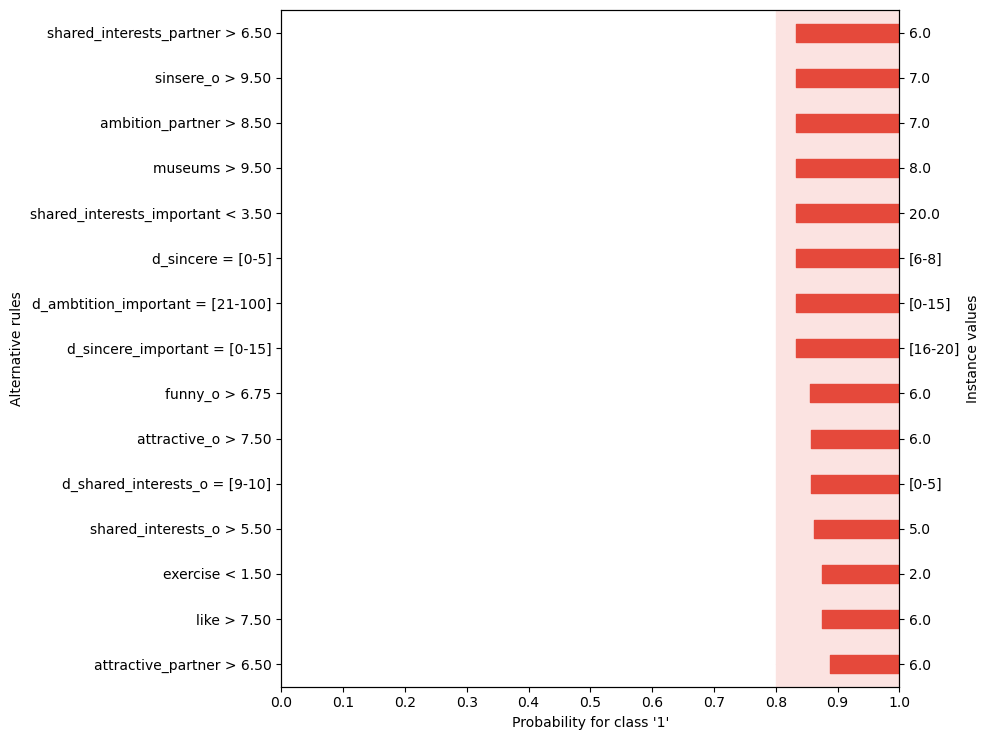

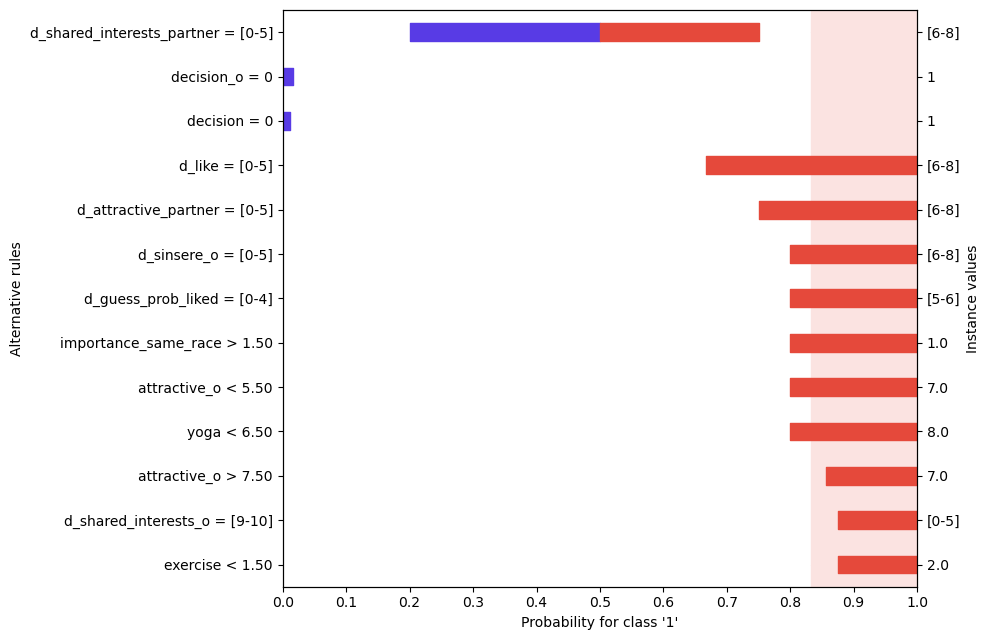

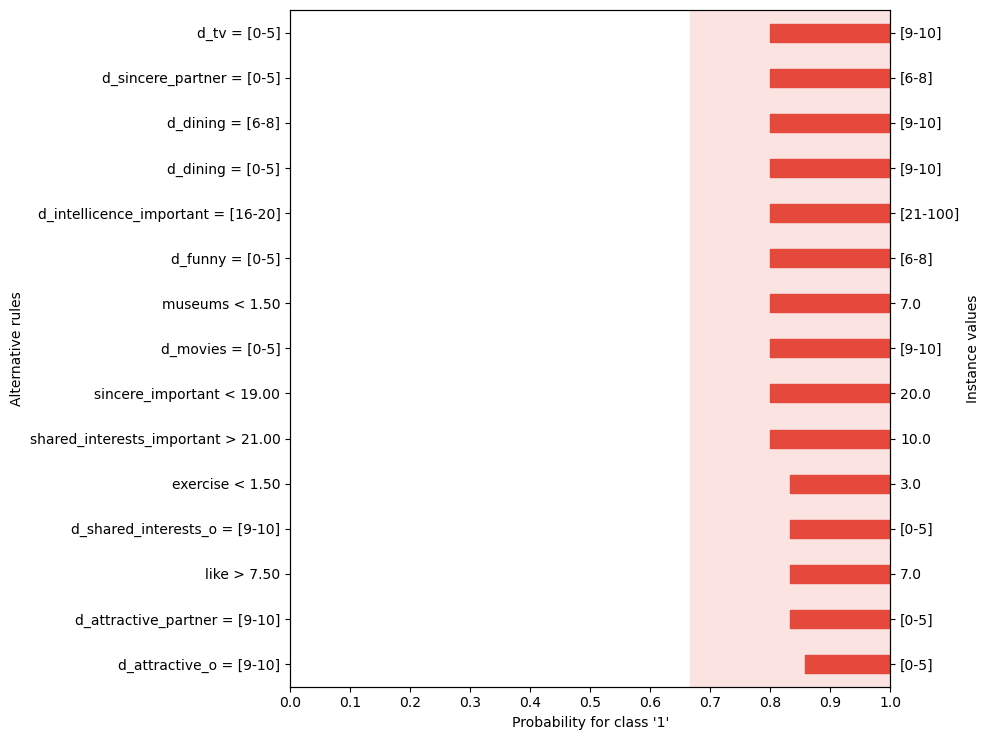

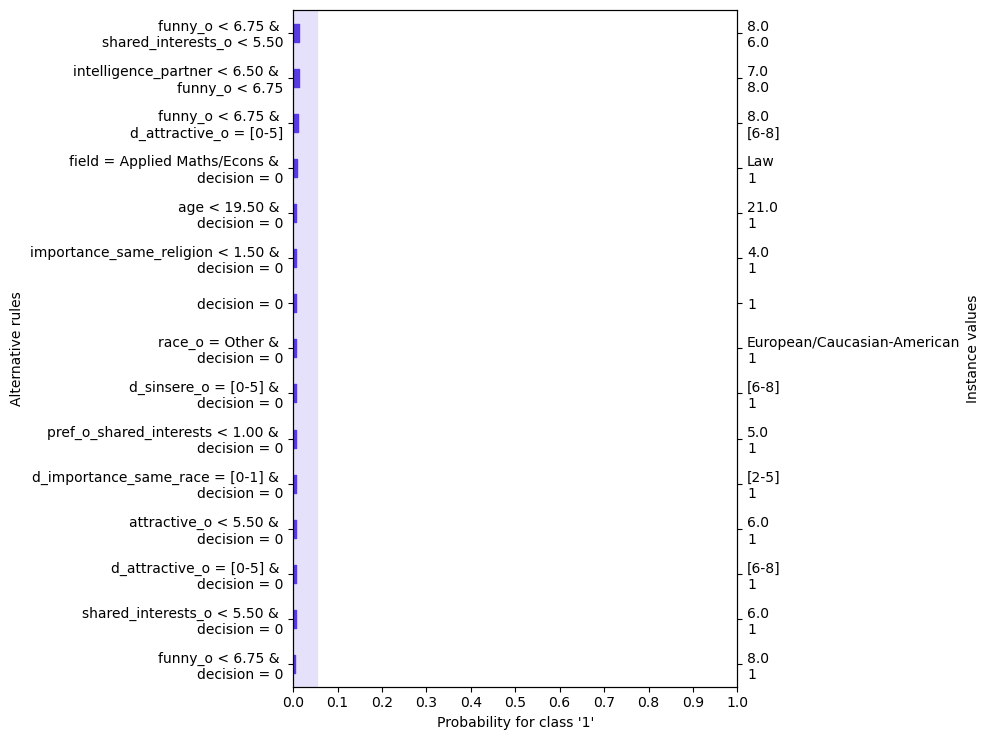

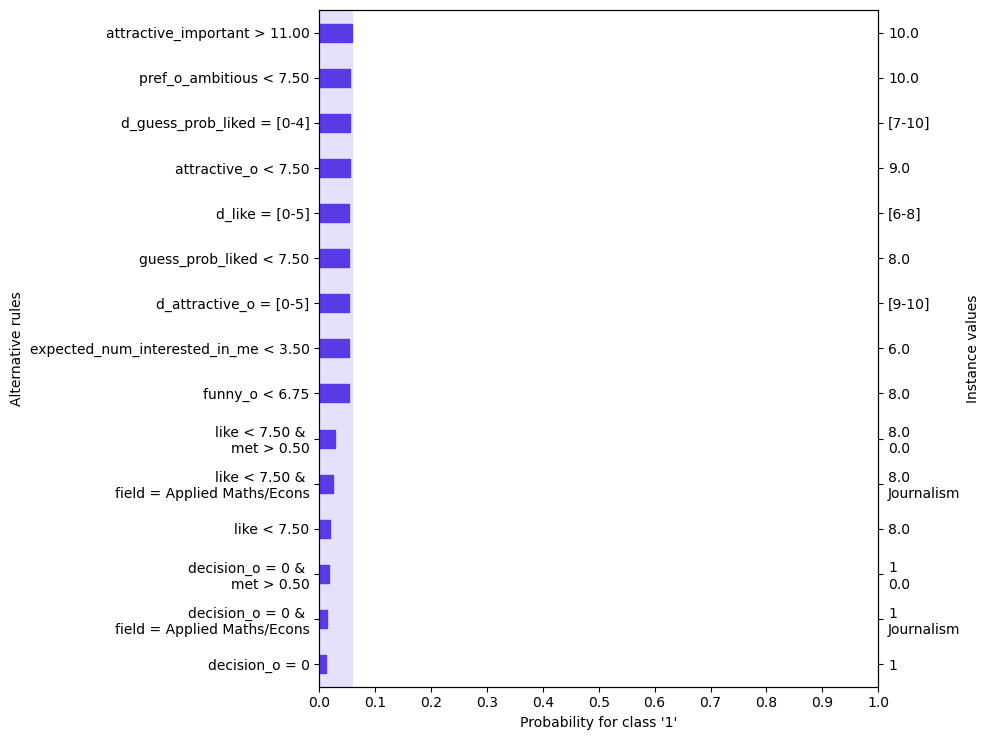

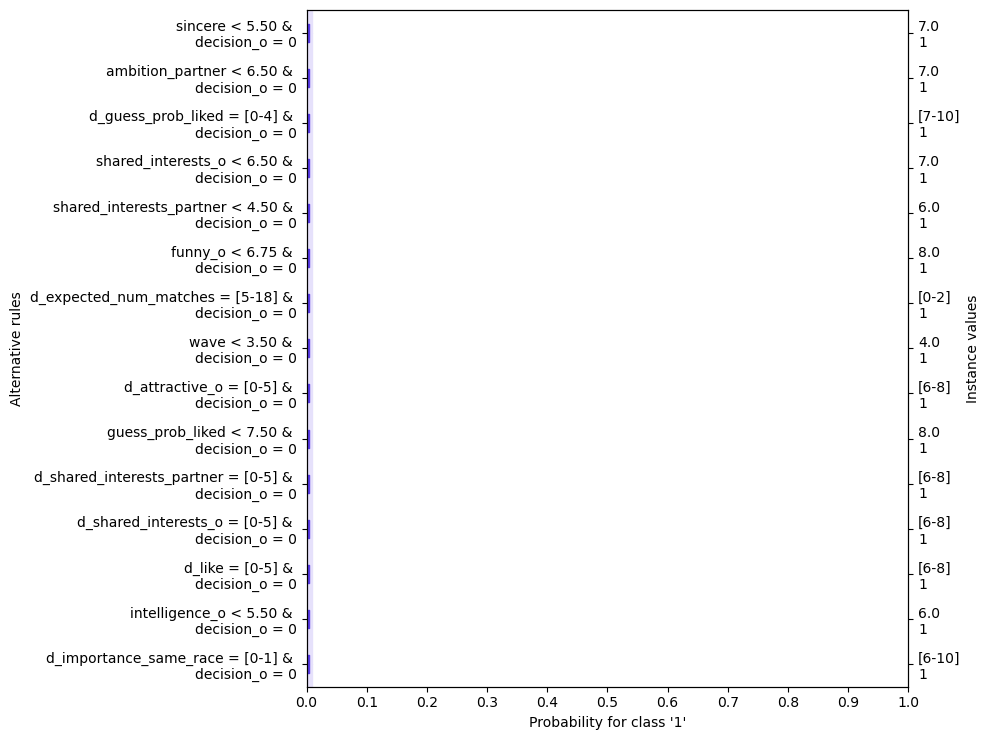

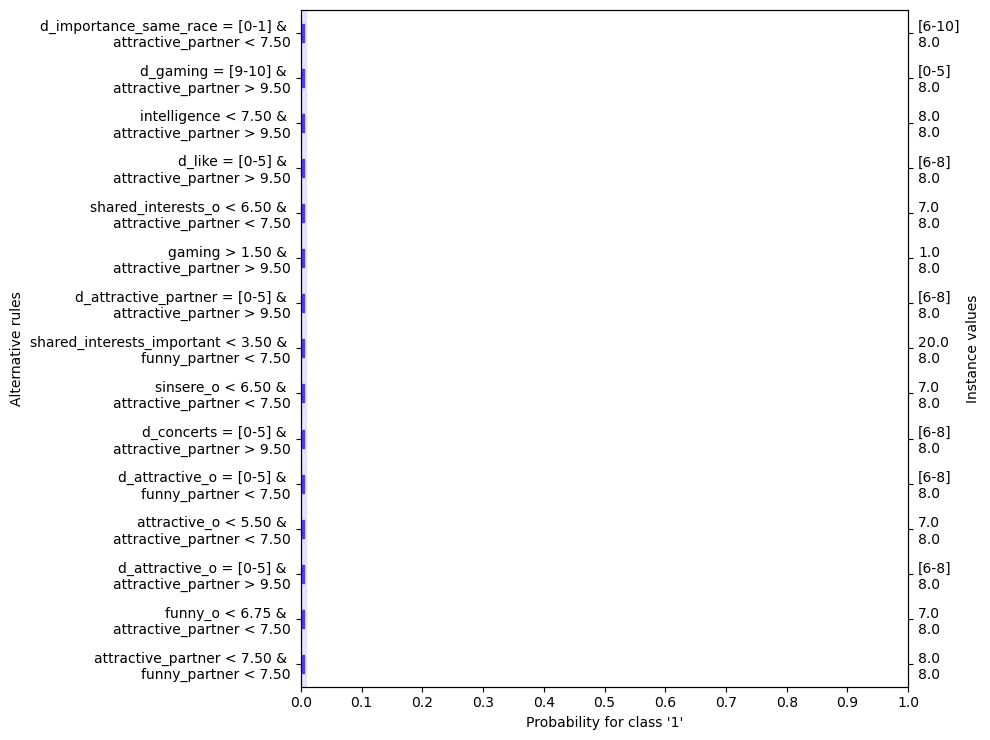

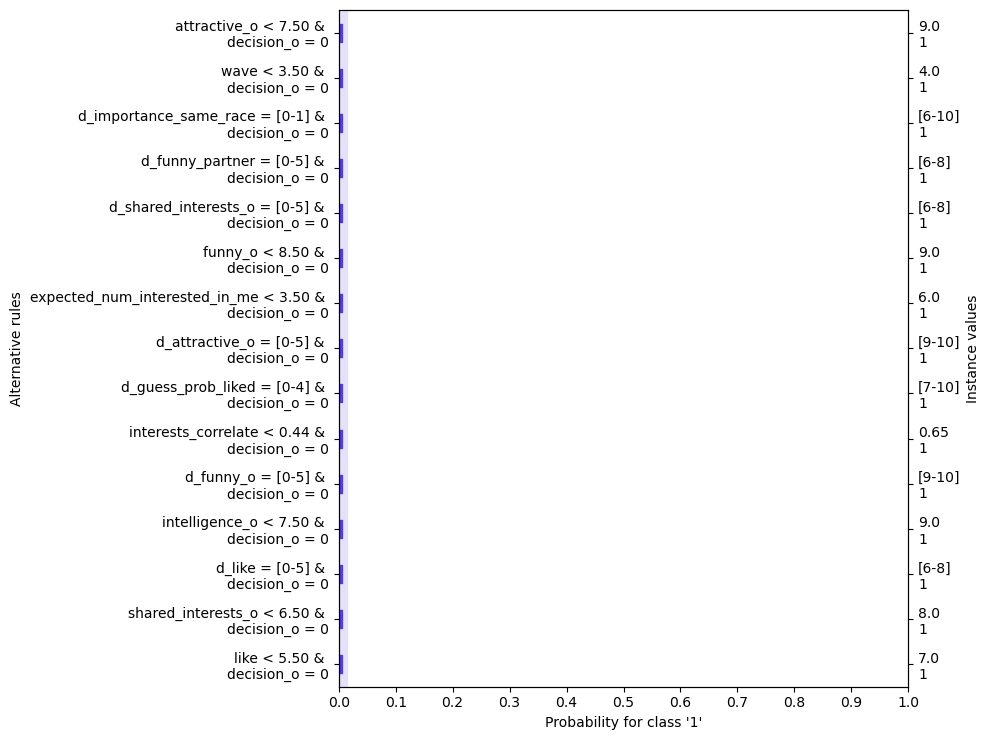

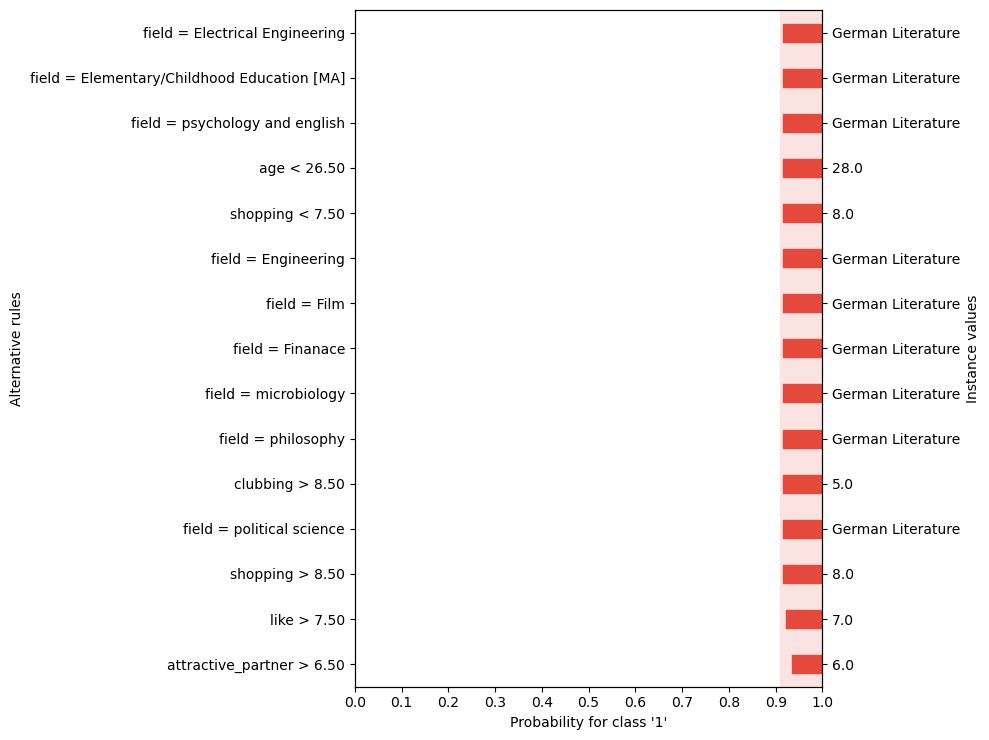

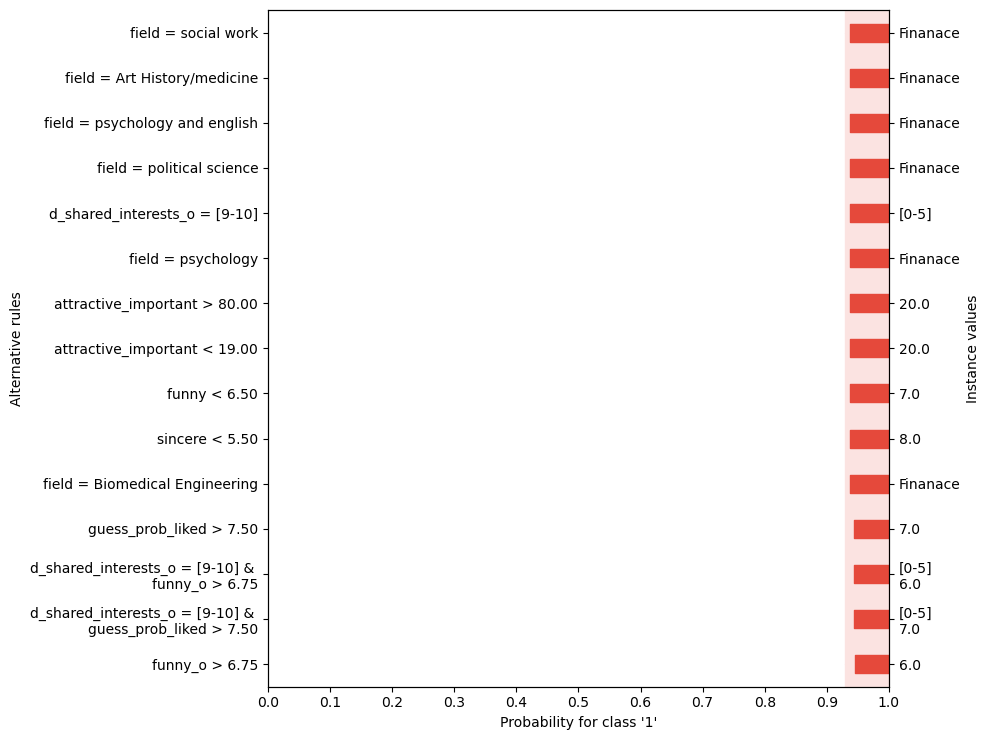

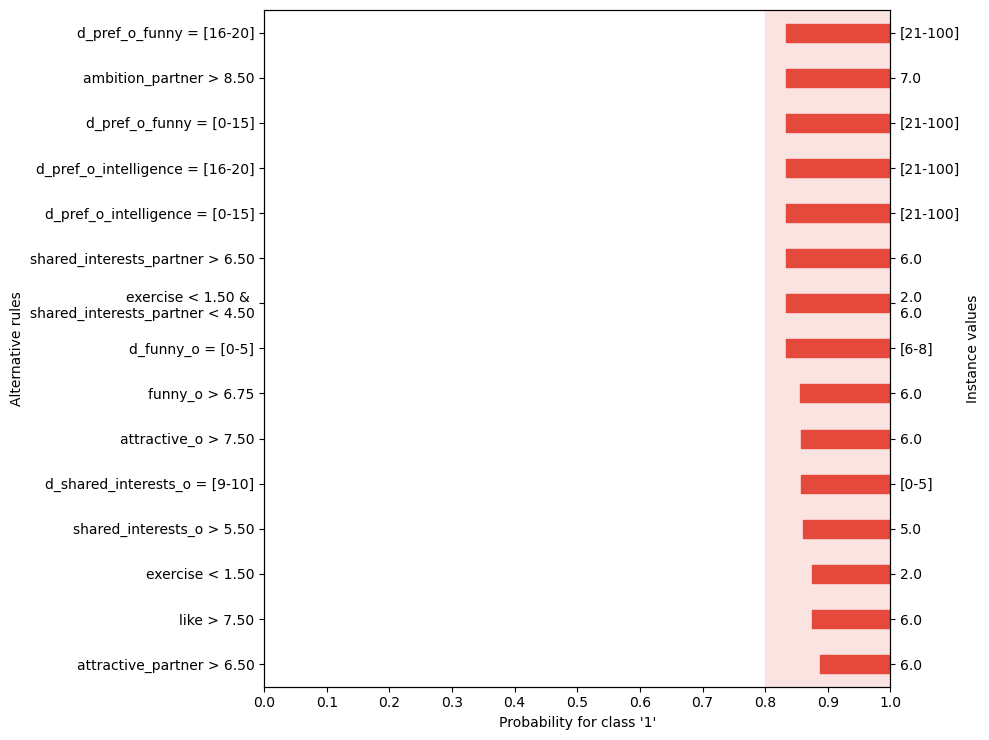

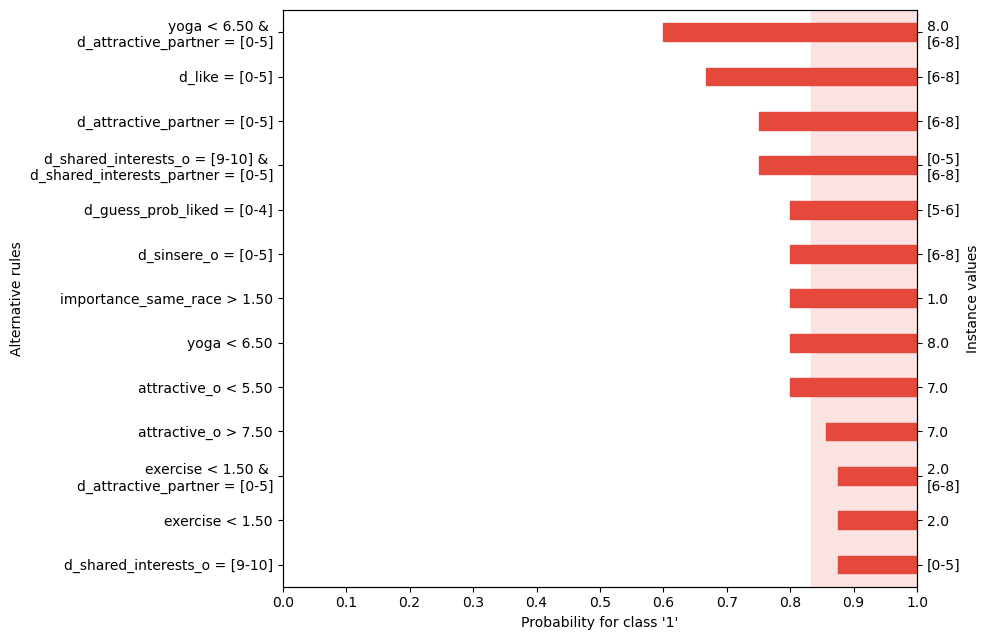

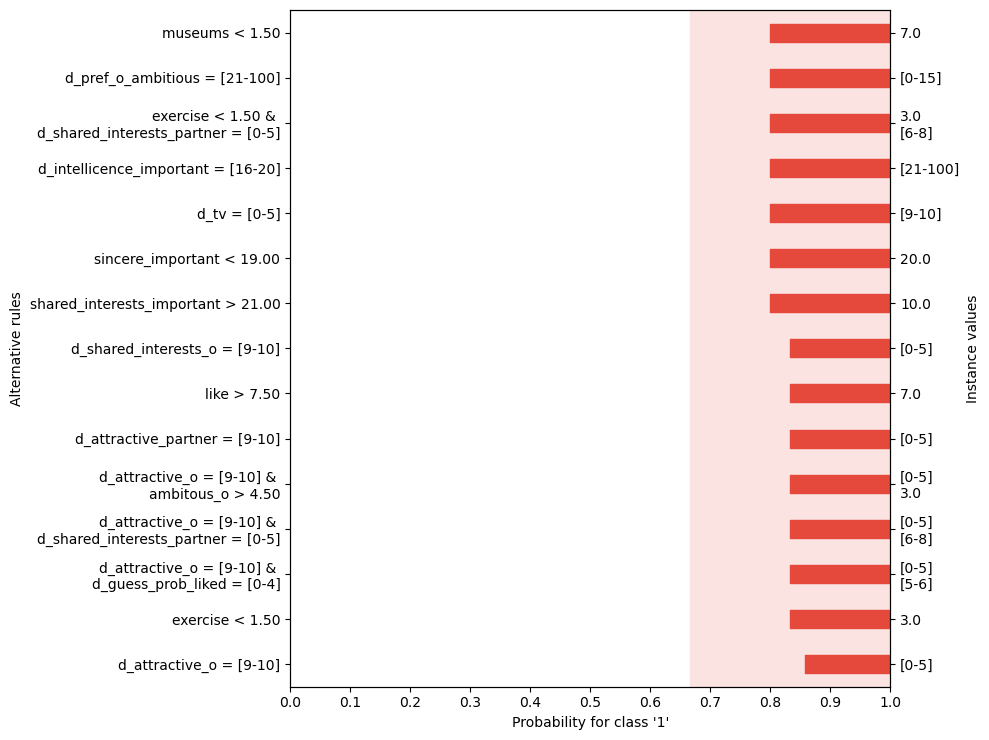

In [10]:
tic = time.time()
alternative_explanation.plot(filter_top=15)
print(f"Time taken plotting alternative rules per instance: {(time.time()-tic)/num_to_test}")
tic = time.time()
exp = alternative_explanation.add_conjunctions()
print(f"Time taken constructing conjunctive rules per instance: {(time.time()-tic)/num_to_test}")
tic = time.time()
alternative_explanation.plot(filter_top=15)
print(f"Time taken plotting alternative and conjunctive rules per instance: {(time.time()-tic)/num_to_test}")

In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print('Performance of underlying model on test set')
print(classification_report(y_test, y_pred, target_names=df[target].unique().astype(str)))
y_va = [int(va > 0.5) for va in [e.prediction['predict'] for e in alternative_explanation.explanations]]
print('Performance of calibration model on test set')
print(classification_report(y_test, y_va, target_names=df[target].unique().astype(str)))
print('target, model pred, model prob, va pred, va prob')
print(*zip(y_test, y_pred, y_proba[:,1], y_va, [e.prediction['predict'] for e in alternative_explanation.explanations]), sep='\n')

Performance of underlying model on test set
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10

Performance of calibration model on test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

target, model pred, model prob, va pred, va prob
(0, 0, 0.20559411529458047, 0, 0.05)
(0, 0, 0.22495457798272409, 0, 0.05555555555555555)
(0, 0, 0.08623822987195912, 0, 0.00819672131147541)
(0, 0, 0.0843200981748249, 0, 0.008130081300813009)
(0, 0, 0.134553

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param